In [1]:
import json
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'static_data.json'
model_save_path = 'keypoint_classifier.hdf5'
tflite_save_path = 'keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 3

# Dataset reading

In [4]:
data = None
with open(dataset,'r') as f :
  data = json.load(f)

In [7]:
classNames = list(data.keys())

In [8]:
classNames

['i', 'open', 'close']

In [9]:
classIndexMap = {}
for x,i in enumerate(classNames):
  classIndexMap[i] = x

classIndexMap

{'close': 2, 'i': 0, 'open': 1}

In [11]:
x_ = []
y_ = []

for l in classNames:
  temp_x = data[l]
  temp_y = [classIndexMap[l] for i in range(len(temp_x))]
  x_.extend(temp_x)
  y_.extend(temp_y)

len(x_),len(y_)  

(1803, 1803)

2

In [14]:
X_dataset = np.array(x_).astype(np.float32)

In [15]:
y_dataset = np.array(y_).astype(np.float32)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

(1803, 42)

# Model building

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [20]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 3)                 33        
                                                                 
Total params: 1,103
Trainable params: 1,103
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [22]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [23]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
11/11 [==============================] - ETA: 0s - loss: 1.1076 - accuracy: 0.3491 
Epoch 1: saving model to keypoint_classifier.hdf5
11/11 [==============================] - 3s 32ms/step - loss: 1.1076 - accuracy: 0.3491 - val_loss: 1.0734 - val_accuracy: 0.5233
Epoch 2/1000
 1/11 [=>............................] - ETA: 0s - loss: 1.0811 - accuracy: 0.3594
Epoch 2: saving model to keypoint_classifier.hdf5
11/11 [==============================] - 0s 11ms/step - loss: 1.0779 - accuracy: 0.3846 - val_loss: 1.0525 - val_accuracy: 0.4834
Epoch 3/1000
 1/11 [=>............................] - ETA: 0s - loss: 1.0658 - accuracy: 0.3906
Epoch 3: saving model to keypoint_classifier.hdf5
11/11 [==============================] - 0s 12ms/step - loss: 1.0654 - accuracy: 0.4142 - val_loss: 1.0073 - val_accuracy: 0.6829
Epoch 4/1000
 1/11 [=>............................] - ETA: 0s - loss: 1.0398 - accuracy: 0.4219
Epoch 4: saving model to keypoint_classifier.hdf5
11/11 [==================

In [24]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

4/4 [==============================] - 0s 5ms/step - loss: 0.0586 - accuracy: 0.9933


In [25]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [26]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[2.6873885e-11 9.9964011e-01 3.5982492e-04]
1


# Confusion matrix

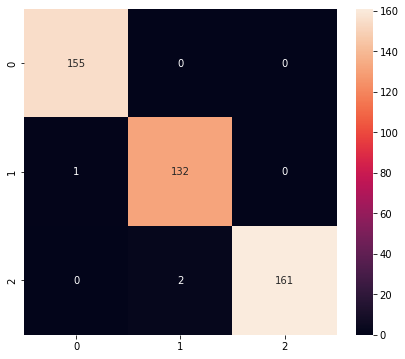

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       155
           1       0.99      0.99      0.99       133
           2       1.00      0.99      0.99       163

    accuracy                           0.99       451
   macro avg       0.99      0.99      0.99       451
weighted avg       0.99      0.99      0.99       451



In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [28]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [29]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpp36d8gs1/assets


6368

# Inference test

In [30]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [31]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [33]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]).astype(np.float32))

In [34]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 1.09 ms, sys: 1.54 ms, total: 2.63 ms
Wall time: 16 ms


In [35]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.6873885e-11 9.9964011e-01 3.5982495e-04]
1


1

array([1, 1, 2, 0, 0, 0, 1, 0, 1, 1, 2, 1, 0, 0, 1, 1, 0, 2, 2, 0, 0, 1,
       2, 0, 0, 1, 2, 2, 2, 2, 2, 2, 0, 1, 1, 0, 2, 2, 2, 1, 0, 2, 2, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 2, 1, 0, 2, 0, 0, 0, 2, 0, 0, 1, 1, 1, 0,
       2, 1, 2, 2, 1, 0, 0, 2, 2, 2, 0, 1, 2, 0, 0, 0, 2, 1, 0, 2, 2, 2,
       1, 0, 0, 0, 0, 2, 2, 1, 1, 0, 1, 0, 2, 2, 1, 1, 2, 2, 2, 0, 0, 0,
       2, 2, 1, 0, 1, 1, 1, 0, 1, 0, 2, 2, 0, 2, 2, 2, 1, 0, 2, 1, 0, 0,
       1, 0, 1, 2, 0, 0, 2, 0, 0, 2, 0, 1, 0, 2, 1, 0, 0, 1, 0, 0, 2, 2,
       0, 0, 1, 1, 1, 0, 2, 0, 2, 0, 0, 0, 1, 2, 0, 2, 2, 2, 2, 0, 2, 1,
       0, 1, 2, 2, 0, 0, 1, 1, 2, 1, 0, 1, 1, 0, 2, 2, 1, 2, 2, 0, 0, 0,
       2, 2, 0, 2, 0, 1, 2, 0, 1, 2, 0, 2, 1, 1, 0, 2, 2, 1, 2, 2, 1, 1,
       0, 1, 1, 2, 2, 0, 0, 0, 2, 2, 0, 1, 1, 0, 0, 2, 2, 0, 1, 0, 1, 2,
       2, 1, 0, 1, 1, 0, 1, 2, 2, 1, 2, 0, 0, 1, 0, 1, 1, 2, 2, 1, 2, 0,
       2, 1, 0, 2, 0, 2, 1, 0, 0, 0, 0, 2, 2, 2, 1, 0, 2, 2, 2, 1, 0, 1,
       0, 2, 1, 2, 2, 1, 1, 0, 0, 0, 0, 2, 0, 0, 2,